In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf

from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras import layers
from keras.models import Model
from keras.applications.inception_v3 import InceptionV3
from keras.layers import Dense, Input, InputLayer, Dropout, Conv2D, MaxPooling2D, Flatten, GlobalAveragePooling2D, BatchNormalization
from keras.callbacks import EarlyStopping as ES
from IPython.display import clear_output as cls
from keras.metrics import AUC
from keras import backend as K


import plotly.express as px
import matplotlib.pyplot as plt

In [2]:
batchSize = 32
imageShape = (224, 224)
epochs = 10
channels = 3

train_dir = "../tomato/train/"
val_dir = "../tomato/val/"

In [3]:
class_names = sorted(os.listdir(train_dir))
class_names

['Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_spider_mite',
 'Tomato___Target_Spot',
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
 'Tomato___Tomato_mosaic_virus',
 'Tomato___healthy']

In [4]:
class_dis = [len(os.listdir(train_dir + name)) for name in class_names]
class_dis

[1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]

In [5]:
train_gen = ImageDataGenerator(rescale=(1./255.), validation_split=0.2)
val_gen = ImageDataGenerator(rescale=(1./255.))

train_ds = train_gen.flow_from_directory(train_dir,target_size=imageShape,batch_size=batchSize, subset='training', class_mode='categorical')
val_ds = train_gen.flow_from_directory(train_dir,target_size=imageShape,batch_size=batchSize, subset='validation', class_mode='categorical')

test_ds = val_gen.flow_from_directory(val_dir,target_size=imageShape,batch_size=batchSize, class_mode='categorical')

Found 8000 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
Found 984 images belonging to 10 classes.


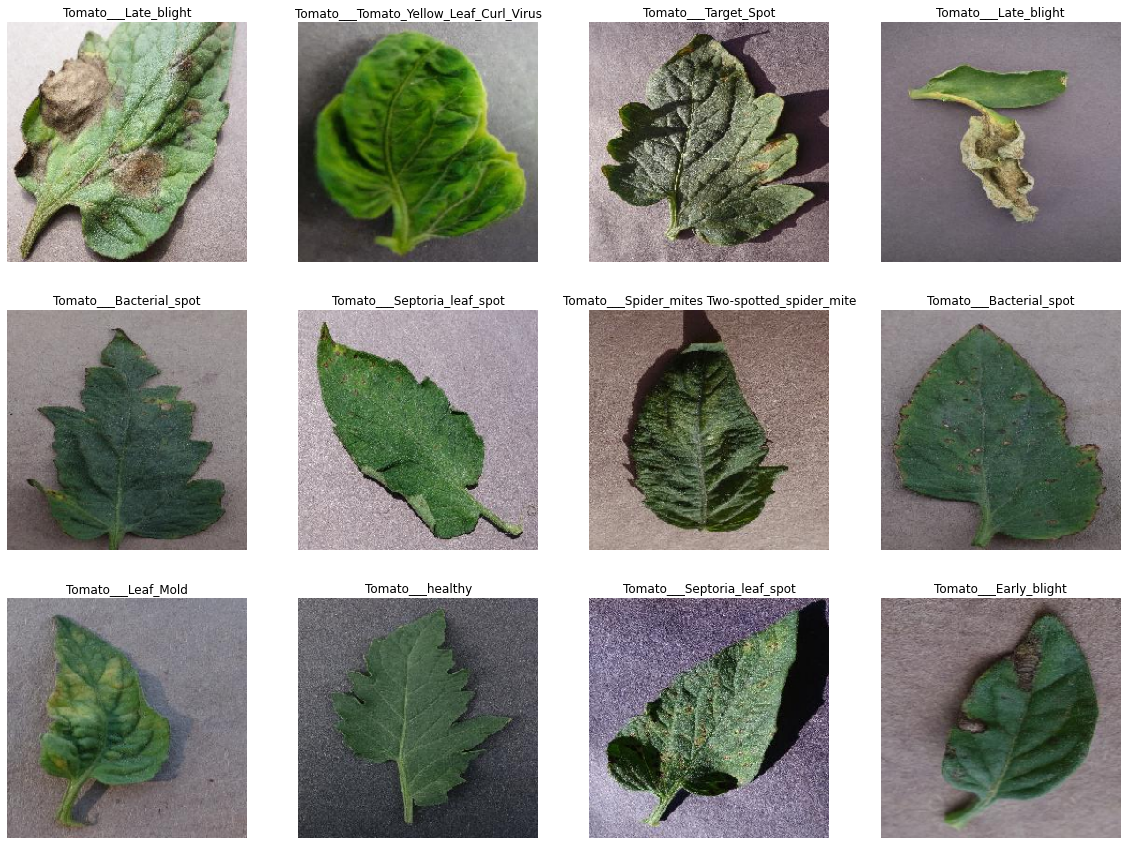

In [6]:
def plot_images(data, class_names):
    r, c = 3, 4
    imgLen = r*c
    plt.figure(figsize=(20, 15))
    i = 1
    for images, labels in iter(data):
        id = np.random.randint(len(images))
        img = tf.expand_dims(images[id], axis=0)
        lab = class_names[np.argmax(labels[id])]
        plt.subplot(r, c, i)
        plt.imshow(img[0])
        plt.title(lab)
        plt.axis('off')
        cls()
        i+=1
        if i > imgLen:
            break
    plt.show()
plot_images(train_ds, class_names)

In [7]:
# F1 Score
def f1_score(y_true, y_pred):
    """Computes the F1 score."""
    y_true = K.round(y_true)
    y_pred = K.round(y_pred)
    tp = K.sum(y_true * y_pred)
    fp = K.sum((1 - y_true) * y_pred)
    fn = K.sum(y_true * (1 - y_pred))
    precision = tp / (tp + fp + K.epsilon())
    recall = tp / (tp + fn + K.epsilon())
    f1_score = 2 * precision * recall / (precision + recall + K.epsilon())
    return f1_score

In [12]:
# AlexNet
def get_model():
    # base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    # for layers in base_model.layers:
    #     layers.trainable = False
    # base_model_output = base_model.output

    images = Input((train_ds.image_shape[0], train_ds.image_shape[1], 3))
    # Architecture - AlexNet
    # 1st Layer
    x = Conv2D(96, kernel_size=(11,11), padding='same', strides=4, activation="relu")(images)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(3,3), strides=2, padding='same')(x)
    # 2nd Layer
    x = Conv2D(256, kernel_size=(5,5), padding='same', strides=1, activation="relu")(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(3,3), strides=2, padding='same')(x)
    # 3rd Layer
    x = Conv2D(384, kernel_size=(3,3), padding='same', strides=1, activation="relu")(x)
    x = BatchNormalization()(x)
    # 4th Layer
    x = Conv2D(384, kernel_size=(3,3), padding='same', strides=1, activation="relu")(x)
    x = BatchNormalization()(x)
    # 5th Layer
    x = Conv2D(256, kernel_size=(3,3), padding='same', strides=1, activation="relu")(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(3,3), strides=2, padding='same')(x)
    # Flatten Layer
    x = Flatten()(x)
    # 1st Full Connected + Dropout Layer
    x = Dense(4096, activation='relu')(x)
    x = Dropout(0.5)(x)
    # 2nd Full Connected + Dropout Layer
    x = Dense(4096, activation='relu')(x)
    x = Dropout(0.5)(x)
    # Final Layer
    x = Dense(len(class_names), activation='softmax')(x)
    
    model = Model(inputs=images, outputs=x)
    return model

modelAlex = get_model()
modelAlex.compile(loss="categorical_crossentropy",
             optimizer="sgd",
             metrics=['accuracy', keras.metrics.Recall(), keras.metrics.Precision(), AUC(), f1_score])
modelAlex.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_10 (Conv2D)          (None, 56, 56, 96)        34944     
                                                                 
 batch_normalization_10 (Bat  (None, 56, 56, 96)       384       
 chNormalization)                                                
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 28, 28, 96)       0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 28, 28, 256)       614656    
                                                                 
 batch_normalization_11 (Bat  (None, 28, 28, 256)      1024  

In [13]:
historyAlex = modelAlex.fit(train_ds,
                   validation_data=val_ds,
                   epochs=10,
                   steps_per_epoch=len(train_ds),
                   validation_steps=len(val_ds),
                   callbacks=[ES(monitor="val_loss", patience=5)])

Epoch 1/10
250/250 [==============================] - 308s 1s/step - loss: 1.9661 - accuracy: 0.4988 - recall: 0.4146 - precision: 0.5725 - auc: 0.8546 - f1_score: 0.4766 - val_loss: 3.7110 - val_accuracy: 0.2250 - val_recall: 0.2120 - val_precision: 0.2343 - val_auc: 0.6779 - val_f1_score: 0.2223
Epoch 2/10
250/250 [==============================] - 330s 1s/step - loss: 0.7981 - accuracy: 0.7333 - recall: 0.6824 - precision: 0.7923 - auc: 0.9626 - f1_score: 0.7322 - val_loss: 0.9372 - val_accuracy: 0.6865 - val_recall: 0.6485 - val_precision: 0.7403 - val_auc: 0.9533 - val_f1_score: 0.6908
Epoch 3/10
250/250 [==============================] - 329s 1s/step - loss: 0.5670 - accuracy: 0.8036 - recall: 0.7669 - precision: 0.8412 - auc: 0.9801 - f1_score: 0.8017 - val_loss: 3.9306 - val_accuracy: 0.3305 - val_recall: 0.3210 - val_precision: 0.3526 - val_auc: 0.6996 - val_f1_score: 0.3335
Epoch 4/10
250/250 [==============================] - 316s 1s/step - loss: 0.4366 - accuracy: 0.8518 - 

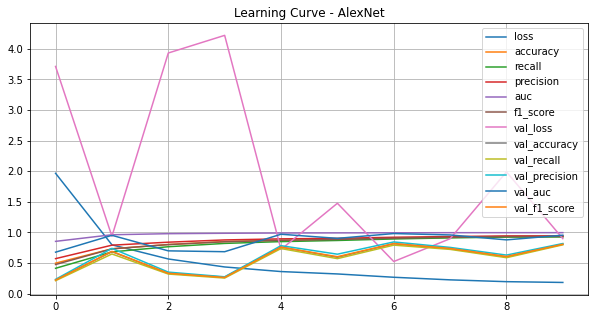

In [14]:
learningcurveAlex = pd.DataFrame(historyAlex.history)
learningcurveAlex.plot(figsize=(10, 5))
plt.title("Learning Curve - AlexNet")
plt.grid()

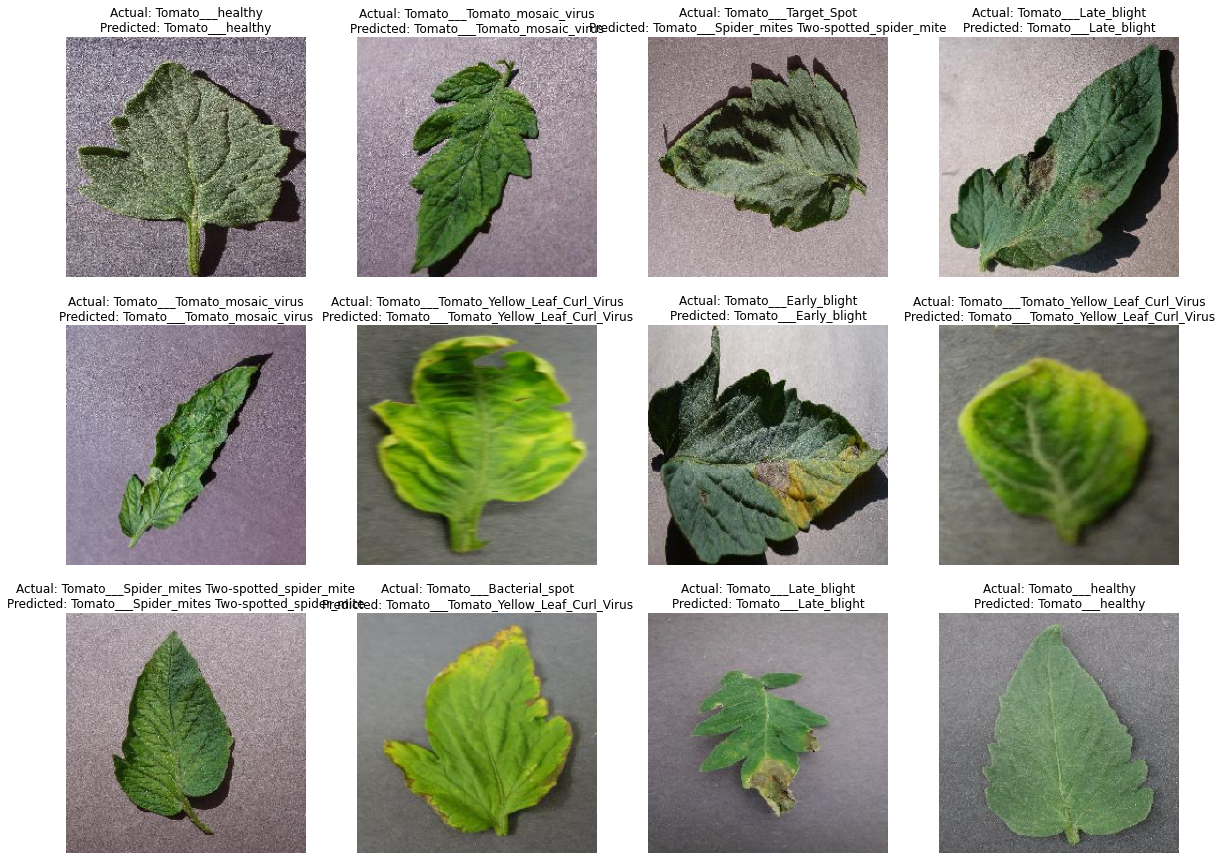

In [15]:
def predictImages(data, class_names, model):
    r, c = 3, 4
    imgLen = r*c
    plt.figure(figsize=(20, 15))
    i = 1
    for images, labels in iter(data):
        id = np.random.randint(len(images))
        img = tf.expand_dims(images[id], axis=0)
        plt.subplot(r, c, i)
        plt.imshow(img[0])
        predicted = model.predict(img)
        predicted = class_names[np.argmax(predicted)]
        actual = class_names[np.argmax(labels[id])]
        plt.title(f"Actual: {actual}\nPredicted: {predicted}")
        plt.axis('off')
        cls()
        i+=1
        if i > imgLen:
            break
    plt.show()
predictImages(test_ds, class_names, modelAlex)

In [18]:
# Predict Test Accuracy
test_generator = val_gen.flow_from_directory(
    '../tomato/val/',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False)
test_acc = modelAlex.evaluate(test_generator)
print('Test accuracy:', test_acc)

Found 984 images belonging to 10 classes.
31/31 [==============================] - 7s 223ms/step - loss: 0.9187 - accuracy: 0.7927 - recall: 0.7815 - precision: 0.8052 - auc: 0.9562 - f1_score: 0.7929
Test accuracy: [0.9187272787094116, 0.792682945728302, 0.7815040946006775, 0.8052356243133545, 0.9561908841133118, 0.7929027676582336]


In [9]:
# Personal Model
def get_model():
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    for layers in base_model.layers:
        layers.trainable = False
    base_model_output = base_model.output

    # Architecture - Custom
    # images = Input((train_ds.image_shape[0], train_ds.image_shape[1], 3))
    # 1st Layer
    x = Conv2D(64, kernel_size=(3,3), padding='same', strides=2, activation="relu")(base_model_output)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2,2), strides=1, padding='same')(x)
    # 2nd Layer
    x = Conv2D(32, kernel_size=(5,5), padding='same', strides=1, activation="relu")(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2,2), strides=1, padding='same')(x)
    # 3rd Layer
    x = Conv2D(256, kernel_size=(2,2), padding='same', strides=1, activation="relu")(x)
    x = BatchNormalization()(x)
    # Flatten Layer
    x = Flatten()(x)
    # 1st Full Connected + Dropout Layer
    x = Dense(2048, activation='relu')(x)
    x = Dropout(0.5)(x)
    # Final Layer
    x = Dense(len(class_names), activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=x)
    return model

modelCustom = get_model()
modelCustom.compile(loss="categorical_crossentropy",
             optimizer="sgd",
             metrics=['accuracy', keras.metrics.Recall(), keras.metrics.Precision(), AUC(), f1_score])
modelCustom.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_3 (Conv2D)              (None, 111, 111, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_3 (BatchNo  (None, 111, 111, 32  96         ['conv2d_3[0][0]']               
 rmalization)                   )                                                             

In [10]:
historyCustom = modelCustom.fit(train_ds,
                   validation_data=val_ds,
                   epochs=10,
                   steps_per_epoch=len(train_ds),
                   validation_steps=len(val_ds),
                   callbacks=[ES(monitor="val_loss", patience=5)])

Epoch 1/10
250/250 [==============================] - 208s 811ms/step - loss: 1.3359 - accuracy: 0.5642 - recall: 0.4756 - precision: 0.6702 - auc: 0.9033 - f1_score: 0.5439 - val_loss: 0.9462 - val_accuracy: 0.6835 - val_recall: 0.5535 - val_precision: 0.8057 - val_auc: 0.9491 - val_f1_score: 0.6561
Epoch 2/10
250/250 [==============================] - 203s 813ms/step - loss: 0.6684 - accuracy: 0.7724 - recall: 0.7224 - precision: 0.8271 - auc: 0.9736 - f1_score: 0.7699 - val_loss: 0.8378 - val_accuracy: 0.7190 - val_recall: 0.6665 - val_precision: 0.7804 - val_auc: 0.9610 - val_f1_score: 0.7186
Epoch 3/10
250/250 [==============================] - 201s 803ms/step - loss: 0.4579 - accuracy: 0.8405 - recall: 0.8070 - precision: 0.8734 - auc: 0.9866 - f1_score: 0.8384 - val_loss: 0.6132 - val_accuracy: 0.7875 - val_recall: 0.7530 - val_precision: 0.8266 - val_auc: 0.9767 - val_f1_score: 0.7870
Epoch 4/10
250/250 [==============================] - 201s 803ms/step - loss: 0.3173 - accurac

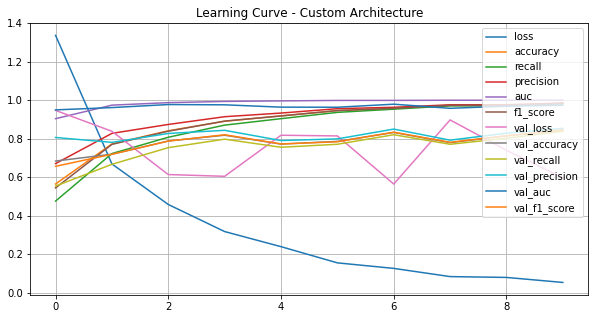

In [11]:
learningcurveCustom = pd.DataFrame(historyCustom.history)
learningcurveCustom.plot(figsize=(10, 5))
plt.title("Learning Curve - Custom Architecture")
plt.grid()

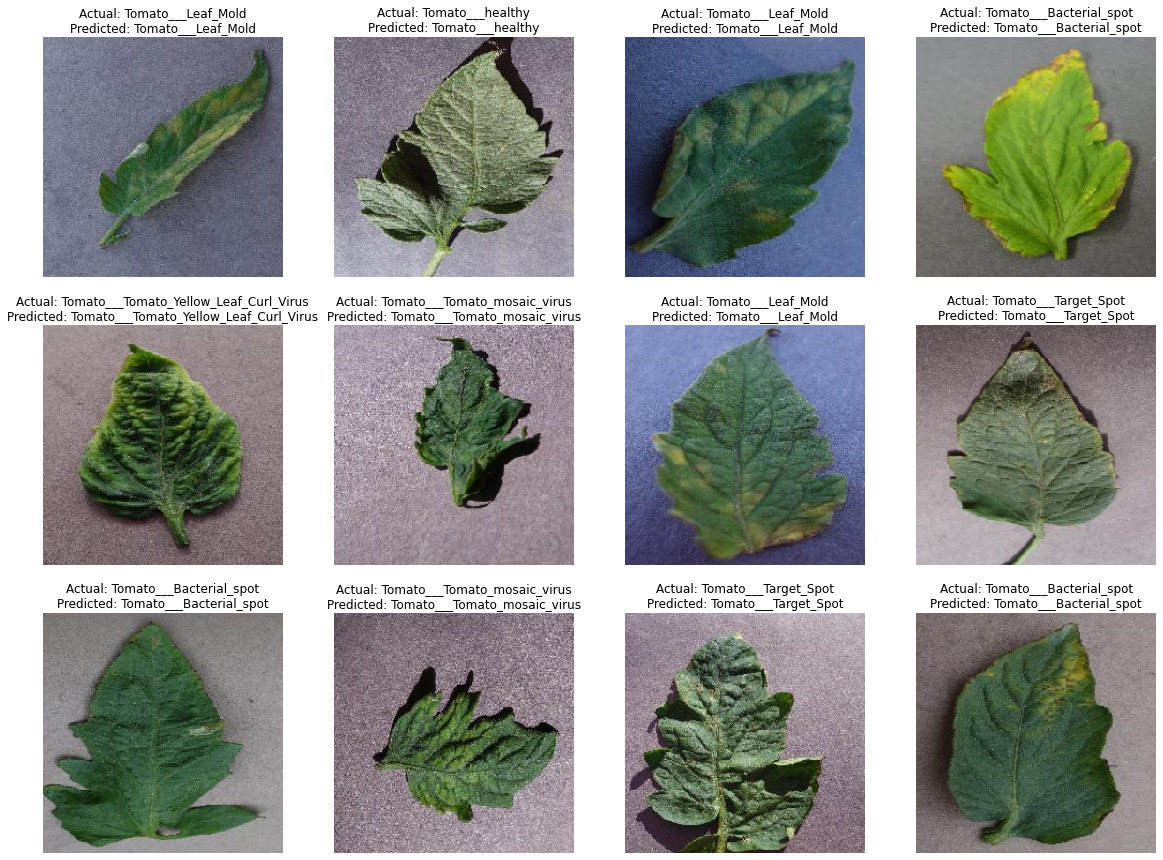

In [12]:
def predictImages(data, class_names, model):
    r, c = 3, 4
    imgLen = r*c
    plt.figure(figsize=(20, 15))
    i = 1
    for images, labels in iter(data):
        id = np.random.randint(len(images))
        img = tf.expand_dims(images[id], axis=0)
        plt.subplot(r, c, i)
        plt.imshow(img[0])
        predicted = model.predict(img)
        predicted = class_names[np.argmax(predicted)]
        actual = class_names[np.argmax(labels[id])]
        plt.title(f"Actual: {actual}\nPredicted: {predicted}")
        plt.axis('off')
        cls()
        i+=1
        if i > imgLen:
            break 
    plt.show()
predictImages(test_ds, class_names, modelCustom)

In [14]:
test_generator = val_gen.flow_from_directory(
    '../tomato/val/',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False)
test_acc = modelCustom.evaluate(test_generator)
print('Test accuracy:', test_acc)

Found 984 images belonging to 10 classes.
31/31 [==============================] - 18s 570ms/step - loss: 0.8024 - accuracy: 0.7988 - recall: 0.7927 - precision: 0.8142 - auc: 0.9628 - f1_score: 0.8010
Test accuracy: [0.8024358749389648, 0.7987805008888245, 0.792682945728302, 0.8141962289810181, 0.9628098607063293, 0.8009937405586243]
